## This is a workbook analysing Stack Overflow Yearly Survey Results (2017)

In [72]:
# Loading libraries

import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
# %matplotlip inline

# libraries
import numpy as np
import matplotlib.pyplot as plt


from scipy.stats import ttest_ind # library to perform t-test

import warnings
warnings.filterwarnings("ignore")

In [73]:
# loading data

df = pd.read_csv('survey-results-public.csv')
df.shape

(51392, 154)

In [74]:
# remove rows with no gender information

df = df.dropna(subset = ['Gender'], axis = 0)
df.shape

(35047, 154)

## EDA Gender

In [75]:
# number of records by gender
df['Gender'].value_counts()

Male                                                       31589
Female                                                      2600
Other                                                        225
Male; Other                                                  171
Gender non-conforming                                        160
Male; Gender non-conforming                                   65
Female; Transgender                                           56
Transgender                                                   55
Female; Gender non-conforming                                 29
Male; Female                                                  15
Transgender; Gender non-conforming                            15
Male; Female; Transgender; Gender non-conforming; Other       15
Male; Transgender                                             11
Female; Transgender; Gender non-conforming                     8
Male; Female; Transgender; Gender non-conforming               7
Gender non-conforming; Ot

Distribution of respondents by gender (raw numbers) 
Male      31589
Female     2600
Others      858
Name: Gender, dtype: int64
Distribution of respondents by gender (percentage) 
Male      90.133250
Female     7.418609
Others     2.448141
Name: Gender, dtype: float64


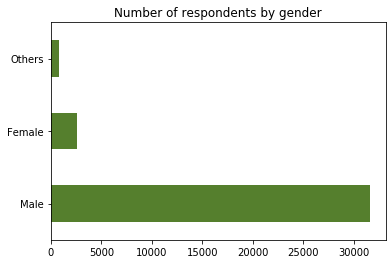

In [76]:
# re-categorise gender field to 'Male', 'Female' and 'Other'
df['Gender'] = np.where(df.Gender == 'Male', 'Male', np.where(df.Gender == 'Female', 'Female', 'Others'))

# Simple distribution of Gender Category
print('Distribution of respondents by gender (raw numbers) \n{}'.format(df['Gender'].value_counts()))
print('Distribution of respondents by gender (percentage) \n{}'.format((df['Gender'].value_counts()/df.shape[0])*100))

(df['Gender'].value_counts()).plot(kind = 'barh', color='#557f2d', title = "Number of respondents by gender")

In [77]:
print("Male survey respondents was {:.2f}".format((sum(df.Gender == 'Male')/df.shape[0])*100))
print("Female survey respondenst was {:.2f}".format((sum(df.Gender == 'Female')/df.shape[0])*100))

Male survey respondents was 90.13
Female survey respondenst was 7.42


## Gender Distribution by Country

In [78]:
#  selecting only countries with at least 1% of all respondents

df_countries = ((df.groupby(['Country'])['Respondent'].count().sort_values(ascending = False)/df.shape[0])>=.01).reset_index()
df_countries = df_countries[df_countries.Respondent == True]

# create a df with only a subset of countries
list_countries = list(df_countries.iloc[:, 0])

subset_df = df[df['Country'].isin(list_countries)]

# print the count by gender
print("Top 18 countries number of respondents by gender\n{}".format(subset_df['Gender'].value_counts()))

Top 18 countries number of respondents by gender
Male      24053
Female     2068
Others      654
Name: Gender, dtype: int64


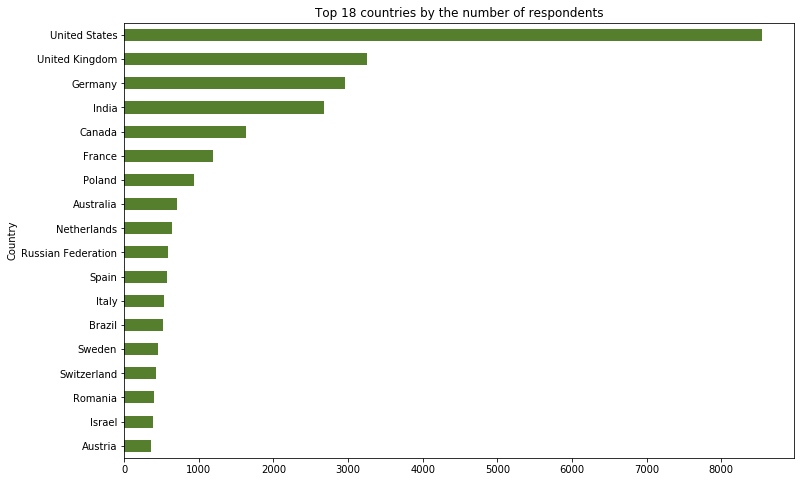

In [79]:
subset_df.groupby(['Country'])['Respondent'].count().sort_values().plot(kind = "barh", figsize = (12,8), color='#557f2d', title = 'Top 18 countries by the number of respondents')

In [80]:
# Country and Gender and proportion of total
groups = subset_df.groupby(['Country', 'Gender'])['Respondent'].count()/subset_df.groupby(['Country'])['Respondent'].count()
groups = groups.reset_index()

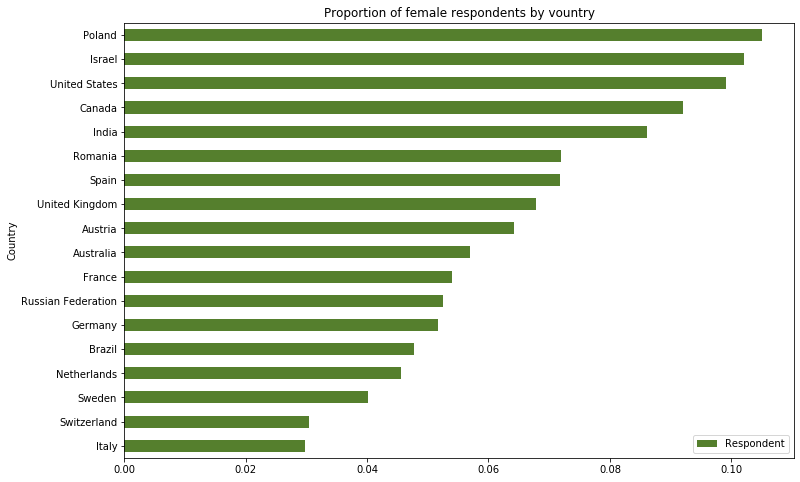

In [81]:
# female respondents as a proportion of all respondents in a country
groups[groups.Gender == 'Female'].sort_values(by = 'Respondent').set_index('Country').plot(kind = 'barh', figsize = (12,8), color='#557f2d', title = "Proportion of female respondents by vountry")

## Gender and Career

In [82]:
def prepare_df(df, column):
    """Outcome: Selected column in the df has no NaN values"""
     # Fill numeric columns with the mean
    if sum(df[column].isna())/df.shape[0]<= 0.3:
        df[column].fillna((df[column].mean()), inplace=True)       
    else:
        df = df.dropna(subset = [column], axis = 0)
    return df

def run_ttest(df, column):
    """Outcome: Selected two values (cat1 and cat2) and compared in the Independent Samples T-Test
    Output: T-test score, and p-value"""
    df = prepare_df(df, column)
    cat1 = df[df['Gender']=='Male']
    cat2 =df[df['Gender']=='Female']

#     print(df.shape)
    return ttest_ind(cat1[column], cat2[column])

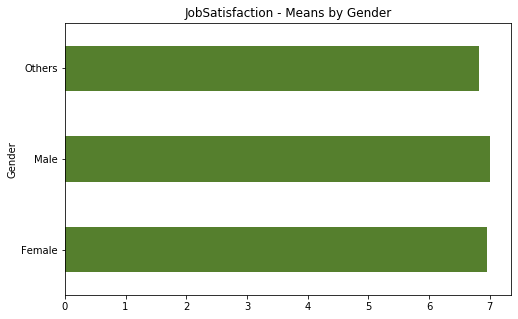

T-test Results: Ttest_indResult(statistic=1.4052392377309995, pvalue=0.15995923669298495)


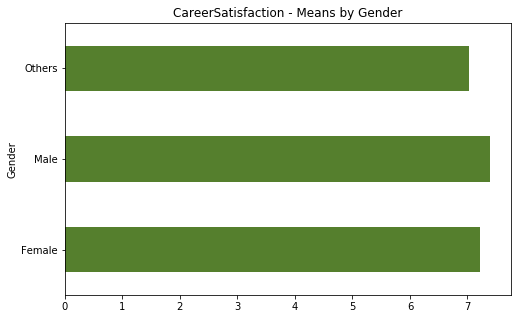

T-test Results: Ttest_indResult(statistic=5.065005553780798, pvalue=4.1050935015467665e-07)


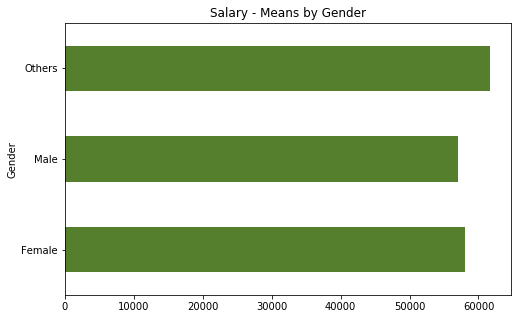

T-test Results: Ttest_indResult(statistic=-0.7564769929054644, pvalue=0.4493787807516285)


In [83]:
list_columns = ['JobSatisfaction', 'CareerSatisfaction', 'Salary']

for column in list_columns:
    df_one_var = prepare_df(df, column)
    df_one_var.groupby('Gender')[column].mean().plot(kind = 'barh', color='#557f2d' , title = column + ' ' + "- Means by Gender", figsize = (8,5))
    plt.show()
    print("T-test Results: {}".format(run_ttest(df_one_var, column)))

#### How many have answered salary questions

In [84]:
df[-df.Salary.isnull()].shape[0]/df.shape[0]

0.3340942163380603

#### How many have answered salary questions by gender

In [85]:
df[-df.Salary.isnull()].groupby(['Gender'])['Respondent'].count()

Gender
Female      819
Male      10666
Others      224
Name: Respondent, dtype: int64

#### Salary respondents by gender distribution

In [86]:
# how many provided salary information
df[-df.Salary.isnull()].groupby(['Gender'])['Respondent'].count()/df[-df.Salary.isnull()].shape[0]

Gender
Female    0.069946
Male      0.910923
Others    0.019131
Name: Respondent, dtype: float64

## Ex-coders answers

In [112]:
def return_question_gender_percentage(df, column, title):
    # creating table with raw numbers of gender count in a given column     
    df_gender = df.groupby(['Gender'])[column].count().reset_index()
    
    # creating table with possible answers for the questions by gender   
    df_question = df.groupby(['Gender', column])['Respondent'].count().reset_index()
    
    #  creating flag for 'agree' responses
    df_question[column] = [item.lower() for item in df_question[column]]
    df_question['agree_flag'] = np.where(df_question[column].str.contains ('disagree'), 0, 1  )
    
    #  creating table with gender and flag counts   
    df_question = df_question.groupby(['Gender', 'agree_flag'])['Respondent'].sum().reset_index()
    
    # joining two tables for calculation percentage
    df_joined = df_gender.join(df_question.set_index('Gender'), on = 'Gender', lsuffix= 'df_gender')
    df_joined["Proportion" + column] = (df_joined.Respondent / df_joined[column])*100

    df_joined = df_joined[df_joined.agree_flag == 1]   
    df_joined = df_joined.drop(['agree_flag'], axis = 1)
    df_joined = df_joined.rename(columns = {column : 'Number of Respondents',
                                           'Respondent': 'Agreed',
                                           "Proportion" + column : '% of Total'})
    
    df = df[-df[column].isna()]
    
    #  creating flag for 'agree' responses
    df[column] = [item.lower() for item in df[column]]
    df['agree_flag'] = np.where(df[column].str.contains ('disagree'), 0, 1  )
    
    
    return print(df_joined),  df_joined[["Gender", '% of Total']].set_index('Gender').plot(kind = 'barh', figsize=(8,4), title = title, color='#557f2d'), print("T-test Results for {}: {}".format(column, run_ttest(return_agree_flag_column(df, column), 'agree_flag')))

   Gender  Number of Respondents  Agreed  % of Total
0  Female                     52      31   59.615385
1    Male                    577     377   65.337955
2  Others                     20      13   65.000000
T-test Results for ExCoderReturn: Ttest_indResult(statistic=0.8270371615121609, pvalue=0.40853062924446226)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x1f823831f88>, None)

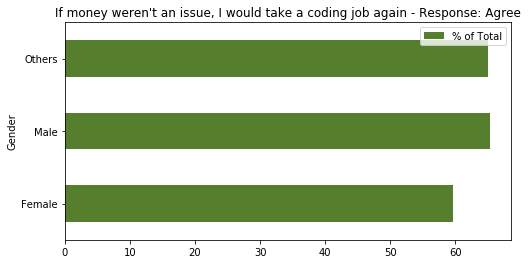

In [113]:
return_question_gender_percentage(df, 'ExCoderReturn', 
                                  "If money weren't an issue, I would take a coding job again - Response: Agree")

   Gender  Number of Respondents  Agreed  % of Total
0  Female                     52      15   28.846154
1    Male                    574     130   22.648084
2  Others                     20       9   45.000000
T-test Results for ExCoderNotForMe: Ttest_indResult(statistic=-1.0136946647413014, pvalue=0.3111213587522601)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x1f82389b848>, None)

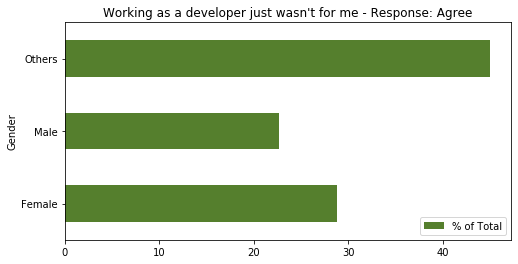

In [114]:
return_question_gender_percentage(df, 'ExCoderNotForMe', 
                                  "Working as a developer just wasn't for me - Response: Agree")

   Gender  Number of Respondents  Agreed  % of Total
0  Female                     51      36   70.588235
1    Male                    576     305   52.951389
2  Others                     20      12   60.000000
T-test Results for ExCoderBalance: Ttest_indResult(statistic=-2.4313148724605553, pvalue=0.015324165786428975)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x1f8239068c8>, None)

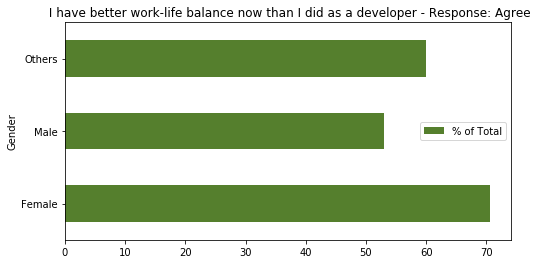

In [115]:
return_question_gender_percentage(df, 'ExCoderBalance', 
                                  ' I have better work-life balance now than I did as a developer - Response: Agree')

   Gender  Number of Respondents  Agreed  % of Total
0  Female                     52      18   34.615385
1    Male                    573     315   54.973822
2  Others                     20       7   35.000000
T-test Results for ExCoder10Years: Ttest_indResult(statistic=2.830932007210688, pvalue=0.004791006353764504)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x1f8237cac88>, None)

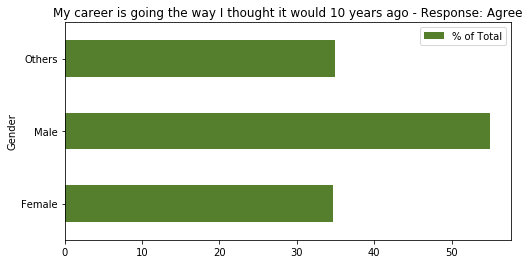

In [116]:
return_question_gender_percentage(df, 'ExCoder10Years', 
                                  'My career is going the way I thought it would 10 years ago - Response: Agree')

   Gender  Number of Respondents  Agreed  % of Total
0  Female                     52      22   42.307692
1    Male                    577     160   27.729636
2  Others                     20      13   65.000000
T-test Results for ExCoderBelonged: Ttest_indResult(statistic=-2.2255748125605495, pvalue=0.026397512649288787)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x1f8239d3248>, None)

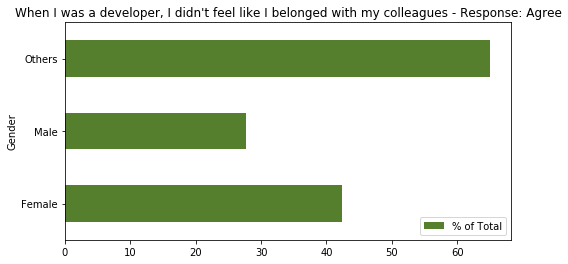

In [117]:
return_question_gender_percentage(df, 'ExCoderBelonged', 
                                  "When I was a developer, I didn't feel like I belonged with my colleagues - Response: Agree")

   Gender  Number of Respondents  Agreed  % of Total
0  Female                     52      42   80.769231
1    Male                    582     374   64.261168
2  Others                     20      11   55.000000
T-test Results for ExCoderSkills: Ttest_indResult(statistic=-2.4083895085613802, pvalue=0.016308324632558106)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x1f823a43888>, None)

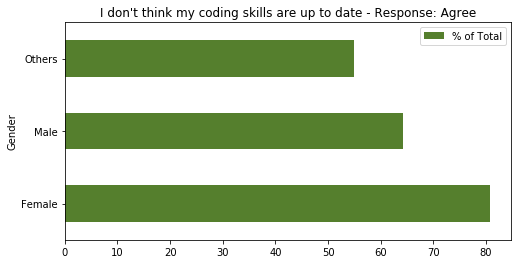

In [118]:
return_question_gender_percentage(df, 'ExCoderSkills', 
                                  "I don't think my coding skills are up to date - Response: Agree")

   Gender  Number of Respondents  Agreed  % of Total
0  Female                     50      24   48.000000
1    Male                    576     228   39.583333
2  Others                     20      12   60.000000
T-test Results for ExCoderWillNotCode: Ttest_indResult(statistic=-1.163491369729425, pvalue=0.24507490094224044)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x1f823abea48>, None)

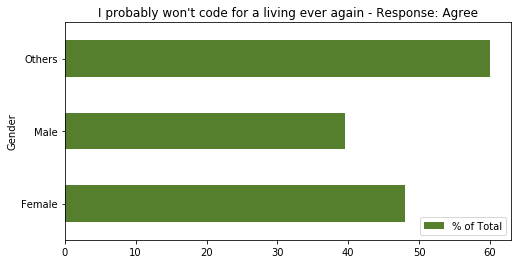

In [119]:
return_question_gender_percentage(df, 'ExCoderWillNotCode', 
                                  "I probably won't code for a living ever again - Response: Agree")

   Gender  Number of Respondents  Agreed  % of Total
0  Female                     52      36   69.230769
1    Male                    584     431   73.801370
2  Others                     20      18   90.000000
T-test Results for ExCoderActive: Ttest_indResult(statistic=0.7141654314478881, pvalue=0.4753877300368814)


(None, <matplotlib.axes._subplots.AxesSubplot at 0x1f823b26cc8>, None)

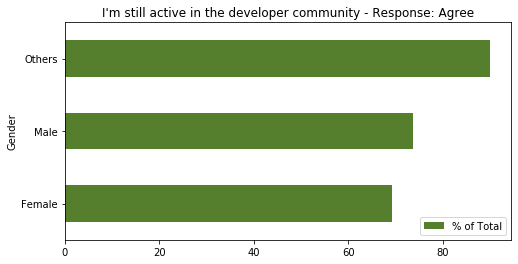

In [120]:
return_question_gender_percentage(df, 'ExCoderActive', 
                                  "I'm still active in the developer community - Response: Agree")